# Week 1 Exerccise: The Earth as an Image — Sentinel‑2 Spectral Exploration

- Kernel: "Python (geoai)"
- AOI path: autodetected (prefers `../data/AOI_boundary.geojson`, fallback `../data/external/aoi.geojson`)
- Outputs saved to `../figures/`

Sections:
1) Imports, paths, and setup
2) Earth Engine init and diagnostics
3) AOI load and verification
4) Sentinel‑2 filter and diagnostics
5) True/False color composites (interactive map)
6) NDVI/NDWI/NDBI layers
7) Spectral profiles plot (saved)
8) Optional: NDVI time series (saved)

Run cells top-to-bottom. If Earth Engine auth fails, see the note in section 2.


In [11]:
from __future__ import annotations
from pathlib import Path
import os
import pandas as pd

# Core geospatial + viz
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

# Reproducibility
import json

# Robust repo root detection from current working directory
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'data').exists() and (p / 'figures').exists():
            return p
    return start

CWD = Path.cwd()
REPO_ROOT = find_repo_root(CWD)

# Prefer AOI at data/AOI_boundary.geojson, fallback to data/external/aoi.geojson
AOI_CANDIDATES = [
    REPO_ROOT / 'data' / 'AOI_boundary.geojson',
    REPO_ROOT / 'data' / 'external' / 'aoi.geojson',
]
AOI_PATH = next((p for p in AOI_CANDIDATES if p.exists()), AOI_CANDIDATES[0])

FIG_DIR = REPO_ROOT / 'figures'

print('CWD:', CWD)
print('Repo root:', REPO_ROOT)
print('Resolved AOI:', AOI_PATH)
print('AOI exists:', AOI_PATH.exists())
print('Figures dir exists:', FIG_DIR.exists())


CWD: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/notebooks
Repo root: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio
Resolved AOI: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/AOI_boundary.geojson
AOI exists: True
Figures dir exists: True


In [2]:
# Earth Engine init with diagnostics and quick auth hint
try:
    ee.Initialize()
    print('Earth Engine initialized successfully')
except Exception as e:
    print('Earth Engine init failed:', e)
    print('If not authenticated, run in a separate cell:')
    print('    import ee; ee.Authenticate(); ee.Initialize()')

# Quick check: print EE user info if available
try:
    user = ee.data.getAssetRoots()
    print('EE Asset roots count:', len(user))
except Exception:
    print('Warning: Could not fetch EE asset roots (may still be fine).')


Earth Engine initialized successfully
EE Asset roots count: 4


In [3]:
# AOI load and verification (GeoJSON)
assert AOI_PATH.exists(), f"AOI not found at {AOI_PATH}"

aoi_gdf = gpd.read_file(AOI_PATH)
assert not aoi_gdf.empty, 'AOI GeoDataFrame is empty'

# Ensure CRS present; default to EPSG:4326 if missing
if aoi_gdf.crs is None:
    aoi_gdf.set_crs(epsg=4326, inplace=True)

# Convert to EE geometry (GeoJSON)
aoi_geojson = json.loads(aoi_gdf.to_crs(epsg=4326).to_json())
# Merge all polygons to a single geometry for EE
from shapely.geometry import shape, mapping
from shapely.ops import unary_union

geoms = [shape(feat['geometry']) for feat in aoi_geojson['features']]
merged = unary_union(geoms)
merged_geojson = mapping(merged)

AOI_EE = ee.Geometry(merged_geojson)

print('AOI CRS:', aoi_gdf.crs)
print('AOI bounds (EPSG:4326):', aoi_gdf.to_crs(epsg=4326).total_bounds)
print('AOI feature count:', len(aoi_geojson['features']))


AOI CRS: EPSG:4326
AOI bounds (EPSG:4326): [-73.11196762 -41.17372783 -72.94210348 -41.06686957]
AOI feature count: 1


In [4]:
# Sentinel-2 filter and diagnostics (2023, <20% clouds)
s2_sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

s2_filtered = (
    s2_sr
    .filterBounds(AOI_EE)
    .filterDate('2023-7-01', '2024-6-30')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
)

count = s2_filtered.size().getInfo()
min_date = ee.Date(s2_filtered.aggregate_min('system:time_start')).format('YYYY-MM-dd').getInfo() if count else 'N/A'
max_date = ee.Date(s2_filtered.aggregate_max('system:time_end')).format('YYYY-MM-dd').getInfo() if count else 'N/A'

print('S2 images found:', count)
print('Date range:', min_date, 'to', max_date)

best_image = s2_filtered.sort('CLOUDY_PIXEL_PERCENTAGE').first()
print('Selected image date:', ee.Date(best_image.get('system:time_start')).format('YYYY-MM-dd').getInfo())
print('Cloud cover (%):', best_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())


S2 images found: 13
Date range: 2023-07-17 to 2024-05-17
Selected image date: 2024-04-12
Cloud cover (%): 0.000922


In [5]:
# True/False color composites (interactive map)
true_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4}  # Red, Green, Blue
false_vis = {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000, 'gamma': 1.4}  # NIR, Red, Green

Map = geemap.Map()
Map.centerObject(AOI_EE, 9)
Map.addLayer(best_image, true_vis, 'True Color (RGB)')
Map.addLayer(best_image, false_vis, 'False Color (NIR-R-G)')
Map.addLayer(AOI_EE, {}, 'AOI outline')
Map


Map(center=[-41.12031538327883, -73.02703554700045], controls=(WidgetControl(options=['position', 'transparent…

In [6]:
# NDVI/NDWI/NDBI layers
ndvi = best_image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = best_image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = best_image.normalizedDifference(['B11', 'B8']).rename('NDBI')

ndvi_vis = {'min': -0.2, 'max': 0.8, 'palette': ['blue', 'white', 'green']}
ndwi_vis = {'min': -0.5, 'max': 0.5, 'palette': ['brown', 'white', 'blue']}
ndbi_vis = {'min': -0.5, 'max': 0.5, 'palette': ['green', 'white', 'gray']}

Map.addLayer(ndvi, ndvi_vis, 'NDVI')
Map.addLayer(ndwi, ndwi_vis, 'NDWI')
Map.addLayer(ndbi, ndbi_vis, 'NDBI')
Map


Map(center=[-41.12031538327883, -73.02703554700045], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
# Spectral profiles for sample points and save figure
import numpy as np

# Sample points (you may adjust to local AOI)
forest_point = ee.Geometry.Point([-73.028383, -41.124933,])
water_point = ee.Geometry.Point([-73.016458, -41.137219])
urban_point = ee.Geometry.Point([-73.054658, -41.124836])
ag_point = ee.Geometry.Point([-73.046583, -41.139317])

Map = geemap.Map()
Map.centerObject(AOI_EE, 10)
Map.addLayer(AOI_EE, {'color': 'yellow'}, 'AOI')

def make_point_layer(name, point, color):
    coords = point.coordinates()
    label = (ee.String(name)
             .cat(': ')
             .cat(ee.Number(coords.get(1)).format('%.6f'))
             .cat(', ')
             .cat(ee.Number(coords.get(0)).format('%.6f')))
    fc = ee.FeatureCollection([ee.Feature(point, {'label': label})])
    styled = fc.style(color=color, pointSize=8, width=2)
    return fc, styled

fc_forest, lyr_forest = make_point_layer('Forest', forest_point, 'orange')
fc_water,  lyr_water  = make_point_layer('Water', water_point, 'blue')
fc_urban,  lyr_urban  = make_point_layer('Urban', urban_point, 'gray')
fc_ag,     lyr_ag     = make_point_layer('Agriculture', ag_point, 'green')

Map.addLayer(lyr_forest, {}, 'Forest')
Map.addLayer(lyr_water,  {}, 'Water')
Map.addLayer(lyr_urban,  {}, 'Urban')
Map.addLayer(lyr_ag,     {}, 'Agriculture')

Map


Map(center=[-41.12031538327883, -73.02703554700045], controls=(WidgetControl(options=['position', 'transparent…

Saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/figures/week1_spectral_profiles.png


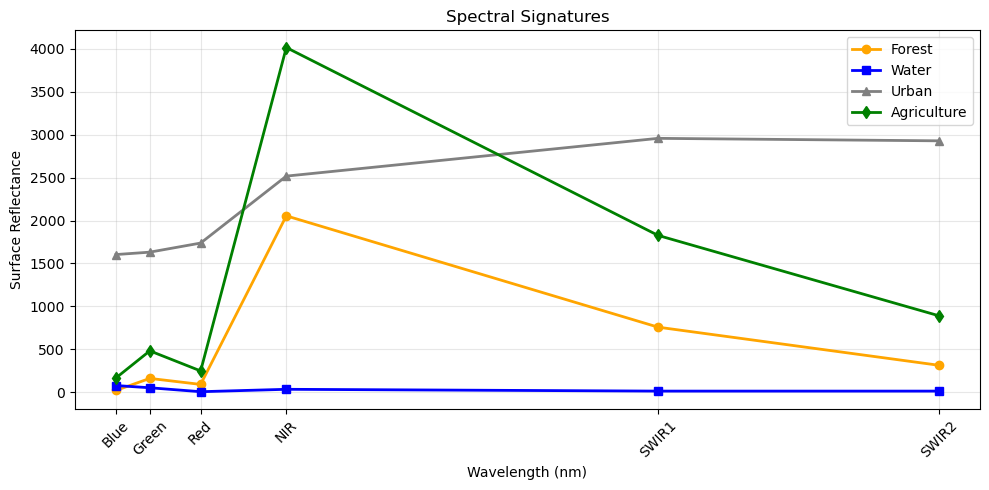

In [8]:
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
wavelengths = [490, 560, 665, 842, 1610, 2190]
band_labels = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']

def get_spectral_profile(image, point, scale=10):
    values = image.select(bands).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point, scale=scale
    ).getInfo() or {}
    return [values.get(b, float('nan')) for b in bands]

forest = get_spectral_profile(best_image, forest_point)
water = get_spectral_profile(best_image, water_point)
urban = get_spectral_profile(best_image, urban_point)
agri = get_spectral_profile(best_image, ag_point)

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, forest, 'o-', label='Forest', linewidth=2, color='orange')
plt.plot(wavelengths, water, 's-', label='Water', linewidth=2, color='blue')
plt.plot(wavelengths, urban, '^-', label='Urban', linewidth=2, color='gray')
plt.plot(wavelengths, agri, 'd-', label='Agriculture', linewidth=2, color='green')

plt.xticks(wavelengths, band_labels, rotation=45)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface Reflectance')
plt.title('Spectral Signatures')
plt.grid(True, alpha=0.3)
plt.legend()
FIG_DIR.mkdir(parents=True, exist_ok=True)
fig_path = FIG_DIR / 'week1_spectral_profiles.png'
plt.tight_layout()
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print('Saved:', fig_path)
plt.show()

### Spectral Signatures
🌲 Forest
	•	Low reflectance in visible bands (Blue, Green, Red), especially in Red (chlorophyll absorption).
	•	Very high reflectance in NIR, due to strong scattering in healthy plant cell structures.
	•	Decreasing reflectance in SWIR bands, since water in leaves absorbs SWIR energy.

➡️ Interpretation: This is a classic healthy vegetation curve — low visible, high NIR, moderate SWIR.

💧 Water
	•	Very low reflectance across all bands, especially in NIR and SWIR (absorbed by water molecules).

➡️ Interpretation: Water bodies absorb most of the light, so they appear dark in satellite imagery. Reflectance barely changes with wavelength.

🏙️ Urban
	•	High and relatively stable reflectance across all bands, with a slight increase toward SWIR.

➡️ Interpretation: Built-up areas (concrete, asphalt, rooftops) reflect more evenly — they don’t have vegetation absorption features. Bright surfaces like concrete contribute to high reflectance in SWIR.

🌾 Agriculture
	•	Moderate visible reflectance, increasing sharply in NIR (similar to vegetation but lower than forest).
	•	Declines slightly in SWIR, depending on crop type and moisture.

➡️ Interpretation: Active cropland has vegetation-like behavior but usually less dense canopy than forest — hence lower NIR reflectance.


Time points: 12


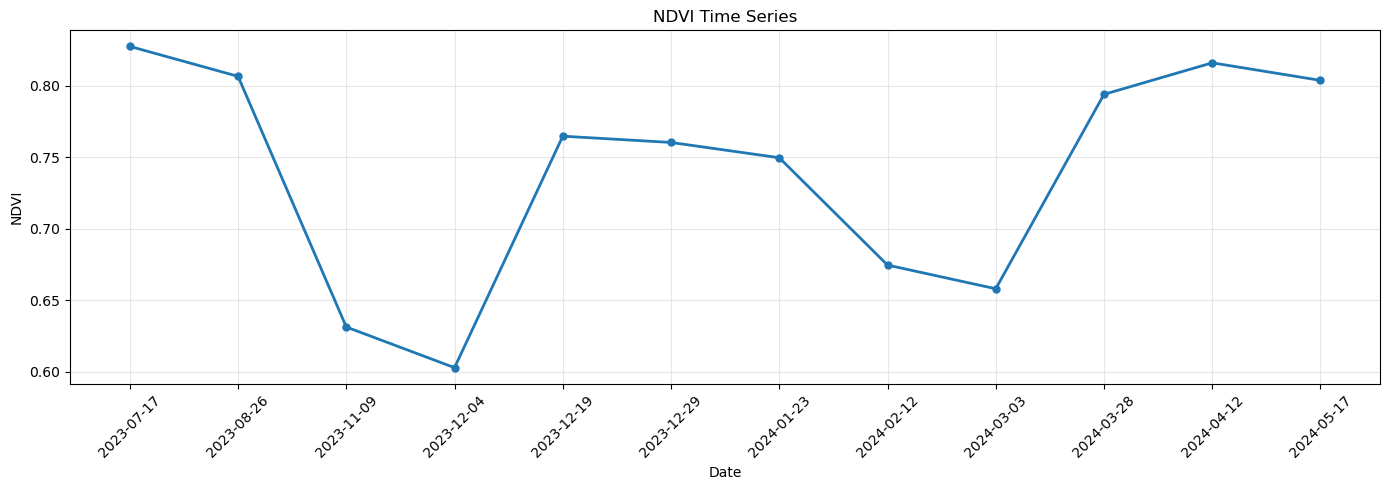

In [12]:
# Time series analysis

# 1) Region: use existing sample_region if defined; else AOI centroid buffer (~600 m)
try:
    region = sample_region
except NameError:
    region = AOI_EE.centroid().buffer(600)

# 2) Base collection: use filtered_collection (Study Guide) else s2_filtered (Lab)
try:
    base = filtered_collection
except NameError:
    base = s2_filtered

# 3) Add NDVI band
def add_ndvi(img):
    return img.addBands(img.normalizedDifference(['B8', 'B4']).rename('NDVI'))

col_ndvi = base.map(add_ndvi)

# 4) Compute NDVI mean at region; drop images with null NDVI
ts_fc = (col_ndvi
    .filterBounds(region)
    .map(lambda img: img.set({
        'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
        'ndvi': img.select('NDVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            bestEffort=True,
            maxPixels=1e9,
            tileScale=2
        ).get('NDVI')
    }))
    .filter(ee.Filter.notNull(['ndvi']))
)

# 5) Bring arrays client-side
dates = ts_fc.aggregate_array('date').getInfo()
ndvis = ts_fc.aggregate_array('ndvi').getInfo()

df = pd.DataFrame({'date': dates, 'ndvi': ndvis}).dropna().sort_values('date')
print('Time points:', len(df))

# 6) Plot and save
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['ndvi'], 'o-', linewidth=2, markersize=5)
plt.xlabel('Date'); plt.ylabel('NDVI')
plt.title('NDVI Time Series'); plt.xticks(rotation=45); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/week1_ndvi_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

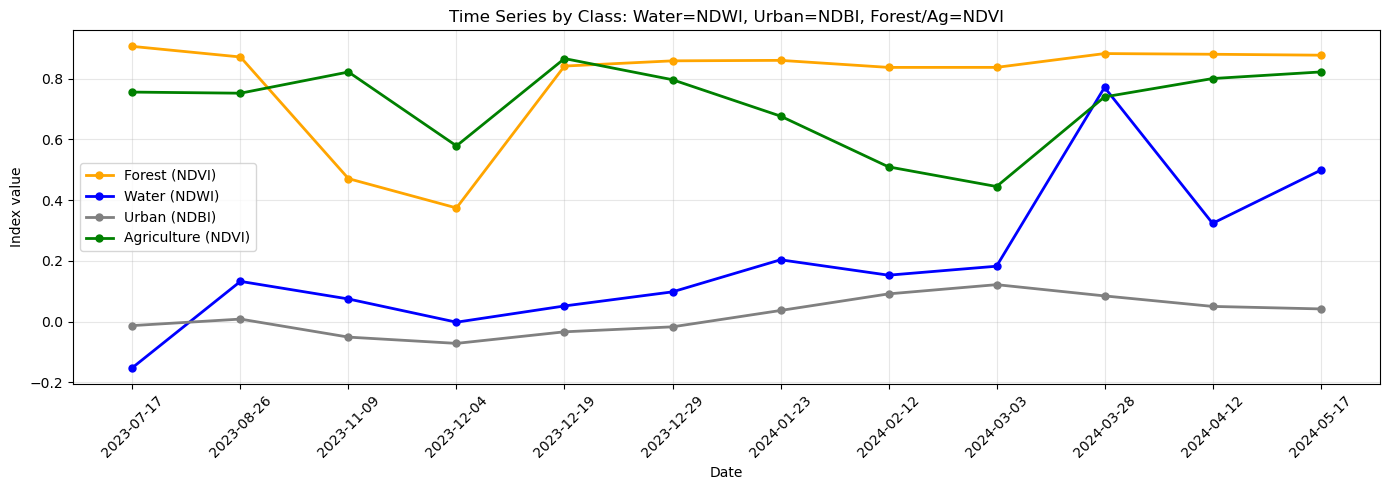

In [13]:
# Time series by class with NDWI for Water, NDVI for Forest/Agriculture, NDBI for Urban

# Base collection
try:
    base = filtered_collection
except NameError:
    base = s2_filtered

def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')  # SWIR1 vs NIR
    return img.addBands([ndvi, ndwi, ndbi])

col_idx = base.map(add_indices)

points = {
    'Forest':      {'geom': forest_point, 'color': 'orange', 'index': 'NDVI'},
    'Water':       {'geom': water_point,  'color': 'blue',   'index': 'NDWI'},
    'Urban':       {'geom': urban_point,  'color': 'gray',   'index': 'NDBI'},
    'Agriculture': {'geom': ag_point,     'color': 'green',  'index': 'NDVI'},
}

buffer_m = 300

def ts_for_point(point, band_name):
    region = point.buffer(buffer_m)
    ts_fc = (col_idx
        .filterBounds(region)
        .map(lambda img: img.set({
            'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
            'value': img.select(band_name).reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=10,
                bestEffort=True,
                maxPixels=1e9,
                tileScale=2
            ).get(band_name)
        }))
        .filter(ee.Filter.notNull(['value']))
    )
    dates = ts_fc.aggregate_array('date').getInfo()
    vals = ts_fc.aggregate_array('value').getInfo()
    return pd.DataFrame({'date': dates, 'value': vals}).dropna().sort_values('date')

plt.figure(figsize=(14, 5))
for name, cfg in points.items():
    df_cls = ts_for_point(cfg['geom'], cfg['index'])
    if len(df_cls):
        plt.plot(df_cls['date'], df_cls['value'], 'o-', linewidth=2, markersize=5,
                 color=cfg['color'], label=f"{name} ({cfg['index']})")

plt.xlabel('Date'); plt.ylabel('Index value')
plt.title('Time Series by Class: Water=NDWI, Urban=NDBI, Forest/Ag=NDVI')
plt.xticks(rotation=45); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
try:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out_path = FIG_DIR / 'week1_timeseries_by_class.png'
except NameError:
    out_path = '../figures/week1_timeseries_by_class.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()